# Two step clustering

This notebook shows the steps for two step clustering using microtumor geometric features. 

In [20]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.interpolate import griddata
import scipy
import matplotlib.pyplot as plt
from skimage.morphology import square, dilation
from skimage import data, util
from skimage.measure import label, perimeter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

import seaborn as sns
import os
import re
import json
import sys
import shutil
import pickle

import pipe_util2
import cc3d_util as cu

In [2]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
def copy_png(start_folder, end_folder, rep, df, predict):
    """
    Helpful function, move microtumor snapshot 
    from original folder to another, grouped by migratory modes

    start_folder - str, folder storing snapshots
    end_folder - str, folder storing sorted tumor snapshots
    rep - list(int)
    df - pd.DataFrame
    predict - list/series
    """
    
    start_folder = pipe_util2.folder_verify(start_folder)
    end_folder = pipe_util2.create_folder(end_folder)
    
    df_temp = df.copy()
    df_temp["mode_predicted"] = predict
    df_temp.dropna(axis = 0, inplace = True)
    
    for m in df_temp["mode_predicted"].unique():
        pipe_util2.create_folder(end_folder+str(m))
    
    i = 0
    while i<df_temp.shape[0]:
        rr = int(df_temp.loc[df_temp.index[i], "rep_inx"])
        sc = int(df_temp.loc[df_temp.index[i], "scan_inx"])
        tt = int(df_temp.loc[df_temp.index[i], "timepoint"])
        mm = int(df_temp.loc[df_temp.index[i], "mode_predicted"])
        
        if rr in rep:
            name = "rep_"+"%s"%rr+"_scan_"+"%s"%sc+"_time_"+"%s"%tt+".png"
            target_sub_folder = pipe_util2.folder_verify(end_folder+str(mm))
            shutil.copy(start_folder+name, target_sub_folder)
        
        i = i+1

# 1. Importing data

In [4]:
figure_folder = "path/to/figure_folder/"
feature_folder = "path/to/feature_folder/"
data_folder = "path/to/data_folder/"

In [ ]:
# looping all geometric feature folder
# combine the data into a pd.DataFrame
geo_csvs = pipe_util2.folder_file_num(feature_folder, ".csv")
df_list = []
i = 0
while i<len(geo_csvs):
    df = pd.read_csv(geo_csvs[i], index_col=0)
    df_list.append(df)
#     if i%1000==0:
#         print(i)
    i = i+1
geo_df = pd.concat(df_list, ignore_index = True)


# removing incomplete records if any
# print incomplete records
for r in geo_df.rep_inx.unique():
    
    for i in geo_df.iter_inx.unique():
        temp = geo_df.loc[(geo_df.rep_inx==r) & (geo_df.iter_inx==i)].copy()
        if temp.shape[0]==1:
            print(temp.shape, r, i)
            geo_df.drop(temp.index, inplace = True)

# define folder for storing the migratory mode clustering results
cluster_folder = "path/to/cluster_folder/" 
pipe_util2.create_folder(cluster_folder)
# save geometric feature results to a .csv file
geo_df.to_csv(cluster_folder+"geo_props.csv")

In [6]:
geo_df = pd.read_csv(cluster_folder+"geo_props.csv", index_col=0)
geo_df.head(3)

,rep_inx,iter_inx,timepoint,scan_f,scan_inx,jasn_file,scan_keys,scan_param,traj,mode_temp,...,minor_major_ratio,compact,eccentric,circular,convexity,solidity,radial_dist_cx_std,radial_dist_cn_mean,radial_dist_cn_std,sphericity
0,0,0,270,/net/capricorn/home/xing/huijing/Migration/CC3...,0,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,0.0 0.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.950037,0.597693,0.312136,0.002093,0.994236,0.976671,1.329195,42.189084,3.199052,0.847031
1,0,0,90,/net/capricorn/home/xing/huijing/Migration/CC3...,0,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,0.0 0.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.968650,0.607727,0.248428,0.002186,1.000000,0.980281,1.191251,41.457714,3.103820,0.854750
2,0,100,270,/net/capricorn/home/xing/huijing/Migration/CC3...,100,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,800.0 120.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.927654,0.429720,0.373441,0.001988,0.864198,0.941906,3.127849,41.493663,7.017041,0.668217


In [7]:
geo_df.columns

Index(['rep_inx', 'iter_inx', 'timepoint', 'scan_f', 'scan_inx', 'jasn_file',
       'scan_keys', 'scan_param', 'traj', 'mode_temp', 'region_n', 'rac_max',
       'rac_mea', 's', 'd', 'd_std', 'dxy_mean', 'dxy_std', 'aa', 'ss',
       'f_coef', 'force_max', 'force_mea', 'fpp', 'p_frac', 'ang_std',
       'ang_mea', 'polarity', 'persis', 'area', 'area_convex', 'area_frac',
       'area_convex_frac', 'peri', 'peri_convex', 'major_axis', 'minor_axis',
       'minor_major_ratio', 'compact', 'eccentric', 'circular', 'convexity',
       'solidity', 'radial_dist_cx_std', 'radial_dist_cn_mean',
       'radial_dist_cn_std', 'sphericity'],
      dtype='object')

In [8]:
scan_param = np.array(geo_df["scan_param"].str.split(" ").to_list()).astype(float).astype(int).T
fpp_scan = scan_param[0]
force_scan = scan_param[1]

geo_df["fpp_scan"] = fpp_scan
geo_df["force_scan"] = force_scan 
geo_df.head(3)

,rep_inx,iter_inx,timepoint,scan_f,scan_inx,jasn_file,scan_keys,scan_param,traj,mode_temp,...,eccentric,circular,convexity,solidity,radial_dist_cx_std,radial_dist_cn_mean,radial_dist_cn_std,sphericity,fpp_scan,force_scan
0,0,0,270,/net/capricorn/home/xing/huijing/Migration/CC3...,0,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,0.0 0.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.312136,0.002093,0.994236,0.976671,1.329195,42.189084,3.199052,0.847031,0,0
1,0,0,90,/net/capricorn/home/xing/huijing/Migration/CC3...,0,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,0.0 0.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.248428,0.002186,1.000000,0.980281,1.191251,41.457714,3.103820,0.854750,0,0
2,0,100,270,/net/capricorn/home/xing/huijing/Migration/CC3...,100,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,800.0 120.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.373441,0.001988,0.864198,0.941906,3.127849,41.493663,7.017041,0.668217,800,120


In [9]:
#geo_df = geo_df.loc[(geo_df.fpp_scan<501)].copy()

In [10]:
# geo df for timepoint 270 (final time point in simulations)
geo_270 = geo_df.loc[geo_df.timepoint==270].reset_index(drop=True).copy()

geo_270.head(3)

,rep_inx,iter_inx,timepoint,scan_f,scan_inx,jasn_file,scan_keys,scan_param,traj,mode_temp,...,eccentric,circular,convexity,solidity,radial_dist_cx_std,radial_dist_cn_mean,radial_dist_cn_std,sphericity,fpp_scan,force_scan
0,0,0,270,/net/capricorn/home/xing/huijing/Migration/CC3...,0,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,0.0 0.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.312136,0.002093,0.994236,0.976671,1.329195,42.189084,3.199052,0.847031,0,0
1,0,100,270,/net/capricorn/home/xing/huijing/Migration/CC3...,100,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,800.0 120.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.373441,0.001988,0.864198,0.941906,3.127849,41.493663,7.017041,0.668217,800,120
2,0,101,270,/net/capricorn/home/xing/huijing/Migration/CC3...,101,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,850.0 120.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.391793,0.002143,0.994203,0.964236,2.471372,41.602812,5.419528,0.717109,850,120


In [11]:
cols = ['s', 'd', 'd_std', 'area_frac', 'area_convex_frac',
        'peri', 'peri_convex', "minor_major_ratio", 'compact',
        'eccentric', 'circular', 'convexity', 'solidity',
        'radial_dist_cx_std', 'sphericity', 'radial_dist_cn_mean',
       'radial_dist_cn_std']

In [12]:
# geo features for differences
geo_df_270 = geo_df.loc[geo_df.timepoint==270][cols].reset_index(drop=True).copy()
geo_df_90 = geo_df.loc[geo_df.timepoint==90][cols].reset_index(drop=True).copy()

geo_diff_df = geo_df_270.divide(geo_df_90, axis='index').copy()
geo_diff_df['dxy_std'] = geo_df[geo_df.timepoint==270].dxy_std.values
geo_diff_df['dxy_mean'] = geo_df[geo_df.timepoint==270].dxy_mean.values
geo_diff_df.tail(3)

,s,d,d_std,area_frac,area_convex_frac,peri,peri_convex,minor_major_ratio,compact,eccentric,circular,convexity,solidity,radial_dist_cx_std,sphericity,radial_dist_cn_mean,radial_dist_cn_std,dxy_std,dxy_mean
11547,0.954955,0.990951,1.018636,0.994275,1.022256,1.040580,1.014535,1.007515,0.918240,0.871526,0.951454,0.974971,0.972629,1.731030,0.923354,0.995052,1.185653,3.139024,7.073131
11548,0.985164,0.999470,1.006070,0.996733,1.021303,1.049853,0.979472,0.975420,0.904319,1.665484,0.955585,0.932961,0.975942,1.381883,0.978447,0.993181,1.109867,1.591003,3.440651
11549,1.020931,1.033692,1.014348,1.044938,1.074627,1.091176,1.023529,1.014586,0.877608,0.540340,0.904847,0.938005,0.972373,1.792275,0.902373,1.020813,1.055311,1.093577,1.955237


In [138]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_model = scaler.fit(geo_diff_df)
scaled_geo_diff = pd.DataFrame(scaler.transform(geo_diff_df))

# Save scaler as pickle object
# reuse when predicting other simulations
with open("scaler1.pkl", "wb") as f:
    pickle.dump(scaled_model, f)
    
scaled_geo_diff.columns = geo_diff_df.columns
scaled_geo_diff.index = geo_diff_df.index
scaled_geo_diff.head(3)

,s,d,d_std,area_frac,area_convex_frac,peri,peri_convex,minor_major_ratio,compact,eccentric,circular,convexity,solidity,radial_dist_cx_std,sphericity,radial_dist_cn_mean,radial_dist_cn_std,dxy_std,dxy_mean
0,-0.619829,-0.416938,-0.581928,0.760413,-0.256649,-0.480504,-0.320484,0.782369,0.873049,-0.768294,0.423519,0.541862,0.505170,-0.788934,1.155880,-0.038534,-0.839529,-1.192794,-1.129975
1,0.040659,-0.211895,-0.352775,0.310779,-0.257846,0.165610,-0.257812,0.532943,-0.485311,-0.536711,0.270858,-1.439392,0.305132,-0.399191,0.168050,-0.549537,-0.185671,-0.516105,-0.586107
2,-0.289663,-0.650265,-0.467399,0.071942,-0.340143,-0.567682,-0.332795,0.401591,0.785712,-0.339542,0.540609,0.840391,0.420133,-0.392451,0.490767,-0.431528,-0.442132,-0.737569,-0.841071


In [61]:
scaled_geo_diff.to_csv(cluster_folder+"scaled_geo_diff.csv")


array([[<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'d'}>,
        <AxesSubplot:title={'center':'d_std'}>,
        <AxesSubplot:title={'center':'area_frac'}>],
       [<AxesSubplot:title={'center':'area_convex_frac'}>,
        <AxesSubplot:title={'center':'peri'}>,
        <AxesSubplot:title={'center':'peri_convex'}>,
        <AxesSubplot:title={'center':'minor_major_ratio'}>],
       [<AxesSubplot:title={'center':'compact'}>,
        <AxesSubplot:title={'center':'eccentric'}>,
        <AxesSubplot:title={'center':'circular'}>,
        <AxesSubplot:title={'center':'convexity'}>],
       [<AxesSubplot:title={'center':'solidity'}>,
        <AxesSubplot:title={'center':'radial_dist_cx_std'}>,
        <AxesSubplot:title={'center':'sphericity'}>,
        <AxesSubplot:title={'center':'radial_dist_cn_mean'}>],
       [<AxesSubplot:title={'center':'radial_dist_cn_std'}>,
        <AxesSubplot:title={'center':'dxy_std'}>,
        <AxesSubplot:title={'center':'dxy_mea

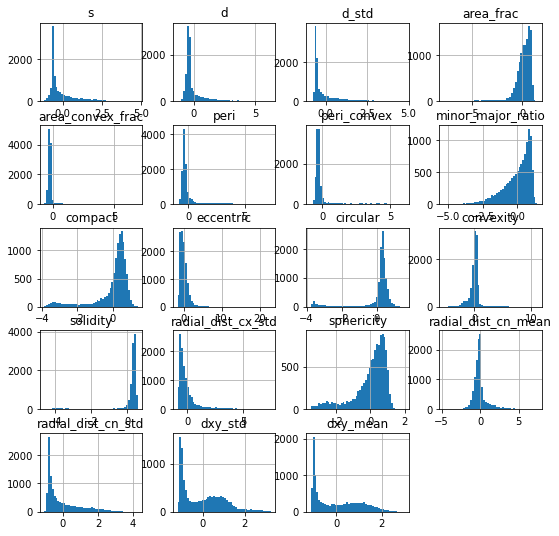

In [14]:
scaled_geo_diff.hist(bins=50, figsize = (9,9))

# 2. Regression/clustering

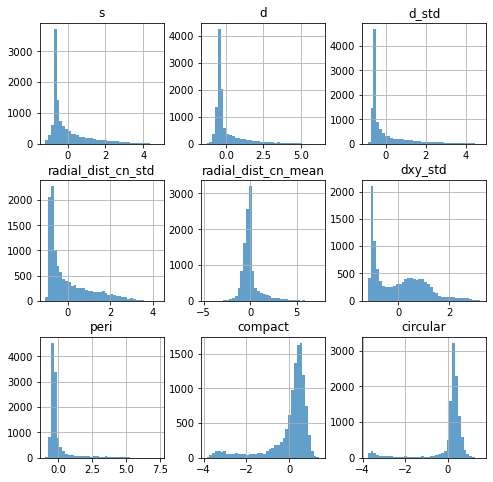

In [62]:
scaled_geo_diff[["s", "d","d_std", 
                 "radial_dist_cn_std",
                 "radial_dist_cn_mean",
                 "dxy_std", 
                 "peri", 'compact', 'circular']].hist(bins=40, alpha=0.7, figsize=(8,8))

plt.savefig("histxx.png", dpi=200, bbox_inches = "tight")

## 2.1 First step clustering

In [119]:
scaled_geo_diff_select = scaled_geo_diff[["s", "d","d_std", 
                                          "radial_dist_cn_std",
                                          "radial_dist_cn_mean",
                                          "dxy_std"]].copy()

reducer = umap.UMAP(
    n_components=2,
    random_state=123,
    n_neighbors=30
)

embedding = reducer.fit_transform(scaled_geo_diff_select)
embedding = pd.DataFrame(embedding)
embedding.shape

(11550, 2)

In [120]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for migrating/non-migrating microtumors
kmean_opt = KMeans(n_clusters = 2, random_state=123)
kmean_model = kmean_opt.fit(scaled_geo_diff_select)

# Save k-mean model for reuse in the future
with open("kmean1.pkl", "wb") as f:
    pickle.dump(kmean_model, f)
    
kmean_geo_diff_select = kmean_model.predict(scaled_geo_diff_select)
geo_270["mode1"] = kmean_geo_diff_select
geo_270["mode2"] = kmean_geo_diff_select
kmean_geo_diff_select

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

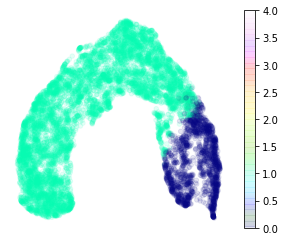

In [121]:
plt.figure(figsize=(5,4))
plt.scatter(
    embedding[[0]], embedding[[1]],
    c=geo_270["mode1"], cmap='gist_ncar', 
    s = 20, lw = 1, alpha=0.1, vmax=4)
plt.colorbar()
plt.axis('off')
#green is 1, blue is 0
plt.savefig("umap3.png", dpi=200, bbox_inches="tight")

In [127]:
mig_mode_num = 0
nmg_mode_num = 1
geo_270.loc[geo_270["mode1"]==nmg_mode_num,"mode1"]=3

## 2.2 Second step clustering

In [128]:
geo_270.head(3)

,rep_inx,iter_inx,timepoint,scan_f,scan_inx,jasn_file,scan_keys,scan_param,traj,mode_temp,...,convexity,solidity,radial_dist_cx_std,radial_dist_cn_mean,radial_dist_cn_std,sphericity,fpp_scan,force_scan,mode1,mode2
0,0,0,270,/net/capricorn/home/xing/huijing/Migration/CC3...,0,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,0.0 0.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.994236,0.976671,1.329195,42.189084,3.199052,0.847031,0,0,3,1
1,0,100,270,/net/capricorn/home/xing/huijing/Migration/CC3...,100,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,800.0 120.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.864198,0.941906,3.127849,41.493663,7.017041,0.668217,800,120,3,1
2,0,101,270,/net/capricorn/home/xing/huijing/Migration/CC3...,101,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,850.0 120.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.994203,0.964236,2.471372,41.602812,5.419528,0.717109,850,120,3,1


In [130]:
scaled_geo_diff_select

,s,d,d_std,radial_dist_cn_std,radial_dist_cn_mean,dxy_std
0,-0.619829,-0.416938,-0.581928,-0.839529,-0.038534,-1.192794
1,0.040659,-0.211895,-0.352775,-0.185671,-0.549537,-0.516105
2,-0.289663,-0.650265,-0.467399,-0.442132,-0.431528,-0.737569
3,-0.448500,-0.555740,-0.607789,-0.579850,-0.630930,-0.717727
4,0.017230,-0.430981,-0.316783,-0.008450,-1.287313,-0.589507
...,...,...,...,...,...,...
11545,-0.804306,-0.791936,-0.763635,-0.875645,-0.895413,-0.876888
11546,-0.316754,-0.475965,-0.550766,-0.469632,-0.486721,-0.759613
11547,-0.653244,-0.703700,-0.575522,-0.753628,-0.539570,-0.542098
11548,-0.636053,-0.627657,-0.617336,-0.795636,-0.581082,-0.931124


In [131]:
cols2 = ["d", "s", "d_std", "peri", 'compact', 'circular',]
scaled_mig_geo_diff_select = scaled_geo_diff[geo_270.mode2==mig_mode_num]
scaled_geo_diff_select = scaled_mig_geo_diff_select[cols2].copy()

reducer = umap.UMAP(
    n_components=2,
    random_state=123,
    n_neighbors=30
)
embedding_modle = reducer.fit(scaled_mig_geo_diff_select)
with open("umap2.pkl", "wb") as f:
    pickle.dump(embedding_modle, f)
embedding = embedding_modle.transform(scaled_mig_geo_diff_select)
embedding = pd.DataFrame(embedding)
embedding.shape

(2240, 2)

In [132]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmean_opt = KMeans(n_clusters = 2, random_state=123)
kmean_model = kmean_opt.fit(embedding)
with open("kmean2.pkl", "wb") as f:
    pickle.dump(kmean_model, f)
kmean_geo_diff_select = kmean_model.predict(embedding)
geo_270.loc[geo_270["mode2"]==mig_mode_num,"mode1"] = kmean_geo_diff_select
kmean_geo_diff_select

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

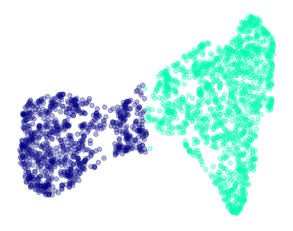

In [133]:
plt.figure(figsize=(5,4))
plt.scatter(
    embedding[[0]], embedding[[1]],
    c=kmean_geo_diff_select, cmap='gist_ncar', 
    s = 20, lw = 1, alpha =0.3, vmax=4)
#plt.colorbar()
plt.axis('off')
plt.savefig("umapxx.png", dpi=200, bbox_inches="tight")

In [135]:
rad_mode_num = 0
dir_mode_num = 1
geo_270.loc[geo_270["mode1"]==rad_mode_num,"mode1"]=4
geo_270.loc[geo_270["mode1"]==dir_mode_num,"mode1"]=5

In [136]:
geo_270['mode1'] = geo_270['mode1']-2
geo_270.head(3)

,rep_inx,iter_inx,timepoint,scan_f,scan_inx,jasn_file,scan_keys,scan_param,traj,mode_temp,...,convexity,solidity,radial_dist_cx_std,radial_dist_cn_mean,radial_dist_cn_std,sphericity,fpp_scan,force_scan,mode1,mode2
0,0,0,270,/net/capricorn/home/xing/huijing/Migration/CC3...,0,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,0.0 0.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.994236,0.976671,1.329195,42.189084,3.199052,0.847031,0,0,1,1
1,0,100,270,/net/capricorn/home/xing/huijing/Migration/CC3...,100,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,800.0 120.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.864198,0.941906,3.127849,41.493663,7.017041,0.668217,800,120,1,1
2,0,101,270,/net/capricorn/home/xing/huijing/Migration/CC3...,101,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,850.0 120.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.994203,0.964236,2.471372,41.602812,5.419528,0.717109,850,120,1,1


In [137]:
geo_270.to_csv(cluster_folder+"geo_270.csv")


# 3. Plot phase graph for tumor migratory modes

In [109]:
def counts_from_df_w_mode_col(df, mode_col, scan_param1, scan_param2):
    # obtain the modes in order. 
    # scan_param2 will be the row.
    counts_list = []
    param1_len = len(df[scan_param1].unique())
    param2_len = len(df[scan_param2].unique())
    
    for a in sorted(df[scan_param1].unique(),reverse=True):
        for f in sorted(df[scan_param2].unique()):
            local_df = df.loc[(df[scan_param1]==a)&(df[scan_param2]==f)].copy()
            counts = [0,0,0]

            i = 0
            while i<len(local_df[mode_col].value_counts()):
                inx = local_df[mode_col].value_counts().index[i]-1
                counts[inx] = local_df[mode_col].value_counts().values[i]
                i = i+1
            counts = np.array(counts)
            counts = counts/counts.sum()
            counts = np.round(counts, 2)
            counts_list.append(counts)
    return counts_list, param1_len, param2_len

In [110]:
def hist_draw(figfolder, counts_list, param1_len, param2_len, name):
    
    """
    drawing the phase graph for the parameter scan

    figfolder - str, folder path for save the figure
    counts_list - list(int), number of mode in repeats 
    param1_len - int, number of param 1 values scanned
    param2_len - int, number of param 2 values scanned
    name - str, figure name
    """
    figfolder = pipe_util2.folder_verify(figfolder)

    i = 0
    height = int(8./param2_len*param1_len)
    if height <1:
        height = 1
    fig = plt.figure(figsize = (8, height),frameon=False)
    while i<len(counts_list):

        fig.add_subplot(param1_len,param2_len,i+1)
        counts = counts_list[i]
        
        y = 1.
        x1 = counts[0]/2.
        w1 = counts[0]
        x2 = counts[1]/2.+w1
        w2 = counts[1]
        x3 = counts[2]/2.+w1+w2
        w3 = counts[2]
        
        plt.bar(x1, y, width=w1, color="#EA3526", alpha=0.9)
        plt.bar(x2, y, width=w2, color="#94FAC4")
        plt.bar(x3, y, width=w3, color="#4D51F2")
        
        plt.ylim(0,1)
        plt.xlim(0,1)

        plt.axis("off")

        i = i+1
        
    plt.savefig(figfolder+"%s.pdf"%name, dpi = 200, bbox_inches="tight")


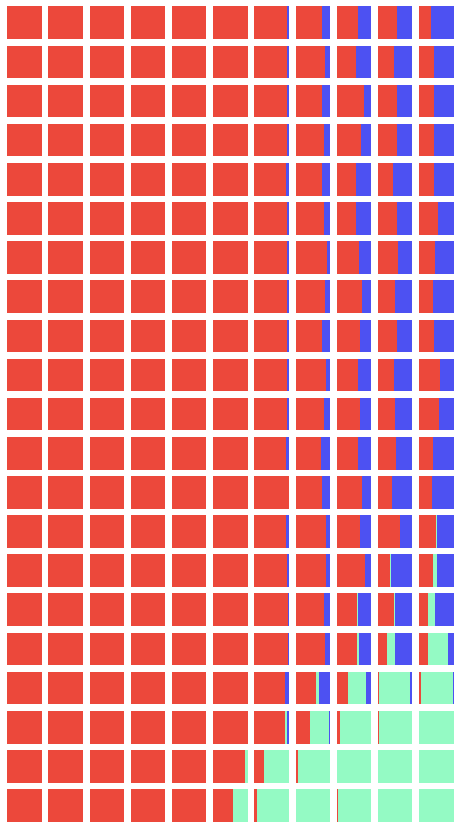

In [113]:
end_folder = "12222021_formal5_hope_force_fpp_scan_pngs_whole_umapdiff/"
counts_list, param1_len, param2_len = counts_from_df_w_mode_col(geo_270, 
                                                                   "mode1", 
                                                                   "fpp_scan", "force_scan")
hist_draw(end_folder, counts_list, param1_len, param2_len, "3_migration_phase_hist_full_select")

# 4. Checking results 

## 4.1 collecting snapshots by condition

In [933]:
def copy_png_by_con(start_folder, end_folder, condition, df):
    """
    copy simulation snapshot to a new folder
    based on its migratory mode

    condition - list containing two values of the scan parameters
    """
    
    start_folder = pipe_util2.folder_verify(start_folder)
    end_folder = pipe_util2.create_folder(end_folder)
    
    df_temp = df.copy()
    df_temp.dropna(axis = 0, inplace = True)
    
    for m in df_temp["mode1"].unique():
        pipe_util2.create_folder(end_folder+str(m))
    
    i = 0
    while i<df_temp.shape[0]:
        rr = int(df_temp.loc[df_temp.index[i], "rep_inx"])
        sc = int(df_temp.loc[df_temp.index[i], "scan_inx"])
        tt = int(df_temp.loc[df_temp.index[i], "timepoint"])
        mm = int(df_temp.loc[df_temp.index[i], "mode1"])
        fpp = int(df_temp.loc[df_temp.index[i], "fpp_scan"])
        force = int(df_temp.loc[df_temp.index[i], "force_scan"])
        
        if force==condition[0] and fpp==condition[1]:
            name = "rep_"+"%s"%rr+"_scan_"+"%s"%sc+"_time_"+"%s"%tt+".png"
            target_sub_folder = pipe_util2.folder_verify(end_folder+str(mm))
            shutil.copy(start_folder+name, target_sub_folder)
        
        i = i+1

In [ ]:
condition1 = [180, 250]
condition2 = [180, 300]
condition3 = [300, 250]

start_folder = figure_folder
end_folder1 = 'path/to/12222021_force_fpp_scan_check_180_250/'
end_folder2 = 'path/to/12222021_force_fpp_scan_check_180_300/'
end_folder3 = 'path/to/12222021_force_fpp_scan_check_300_250/'

copy_png_by_con(start_folder, end_folder1, condition1, geo_270)
copy_png_by_con(start_folder, end_folder2, condition2, geo_270)
copy_png_by_con(start_folder, end_folder3, condition3, geo_270)

## 4.2 Generate movies form .csv files

In [969]:
import imageio;
from skimage.io import imread

def folder_create_movies_from_csvs(folder, save_folder, rep_index, grey = 1, num = 30):
    
    """
    A convient function for print pictures under a folder.
    20 pics at a time.
    """
    fig = plt.figure(figsize=(6, 4))
    folder = pipe_util2.folder_verify(folder)
    save_folder = pipe_util2.folder_verify(save_folder)
    print(folder)
    csv_list = pipe_util2.folder_file_num(folder, ".txt")[:270]
    
    # create a temp folder 
    temp_folder = "temp/"
    temp_folder = pipe_util2.create_folder(temp_folder)
    
    if len(csv_list)<num:
        print("Not enough pictures to print")
        return 1
    
    i_list = (np.linspace(0, len(csv_list), num)[:-1]).astype(int)
    #print(i_list)
    
    # create imgs
    for i in i_list:
        plt.figure(figsize = (5,5))
        df = pd.read_csv(csv_list[i], index_col=0)
        #print(df.columns)
    
        plt.scatter(df.x, df.y, s=40, c=df.f, cmap="rainbow")
        plt.xlim((0,256))
        plt.ylim((0,256))
        plt.axis("off")
        plt.savefig(temp_folder+"%s.png"%str(i).zfill(3), dpi=100, bbox_inches="tight")
        plt.close()
    
    img_path_list = pipe_util2.folder_file_num(temp_folder)
    img_list = []
    for i in np.arange(len(img_path_list)):
        img = imread(img_path_list[i])
        img_list.append(img)
    edges = np.array(img_list)
    imageio.mimwrite(save_folder+'%s.mp4'%rep_index, edges, fps=3)

def create_movie_by_con(end_folder, condition, df):
    """
    rep - list(int)
    predict is a list/series
    """
    
    end_folder = pipe_util2.create_folder(end_folder)
    
    df_temp = df.copy()
    df_temp.dropna(axis = 0, inplace = True)
    
    for m in df_temp["mode1"].unique():
        pipe_util2.create_folder(end_folder+str(m))
    
    i = 0
    while i<df_temp.shape[0]:
        rr = int(df_temp.loc[df_temp.index[i], "rep_inx"])
        sc = int(df_temp.loc[df_temp.index[i], "scan_inx"])
        tt = int(df_temp.loc[df_temp.index[i], "timepoint"])
        mm = int(df_temp.loc[df_temp.index[i], "mode1"])
        fpp = int(df_temp.loc[df_temp.index[i], "fpp_scan"])
        force = int(df_temp.loc[df_temp.index[i], "force_scan"])
        
        if force==condition[0] and fpp==condition[1]:

            folder = df_temp.loc[i, "scan_f"] + "12222021_formal5_hope_force_fpp_scan/"
            target_sub_folder = pipe_util2.folder_verify(end_folder+str(mm))
            folder_create_movies_from_csvs(folder, target_sub_folder, rr, grey = 0, num = 100)
        i = i+1

In [ ]:
condition1 = [180, 250]
condition2 = [180, 300]
condition3 = [300, 250]

end_folder1 = 'path/to/12222021_force_fpp_scan_check_movie_180_250/'
end_folder2 = 'path/to/12222021_force_fpp_scan_check_movie_180_300/'
end_folder3 = 'path/to/12222021_force_fpp_scan_check_movie_300_250/'

create_movie_by_con(end_folder1, condition1, geo_270)
create_movie_by_con(end_folder2, condition2, geo_270)
create_movie_by_con(end_folder3, condition3, geo_270)